         Date       Open       High        Low      Close  Adj Close  \
0  2019-09-01  51.607498  56.605000  51.055000  55.992500  54.180801   
1  2019-10-01  56.267502  62.437500  53.782501  62.189999  60.177776   
2  2019-11-01  62.384998  67.000000  62.290001  66.812500  64.650696   
3  2019-12-01  66.817497  73.492500  64.072502  73.412498  71.250443   
4  2020-01-01  74.059998  81.962502  73.187500  77.377502  75.098686   

       Volume  
0  2170268400  
1  2433210800  
2  1793326000  
3  2388794800  
4  2934370400  
             Open        High         Low       Close   Adj Close  \
count   60.000000   60.000000   60.000000   60.000000   60.000000   
mean   141.232458  151.544583  133.016500  143.935374  142.128315   
std     42.289438   43.186605   40.166348   42.133994   42.569777   
min     51.607498   56.605000   51.055000   55.992500   54.180801   
25%    122.997503  133.302505  114.130625  121.927502  119.492599   
50%    147.520004  157.320000  136.879998  148.434998  14

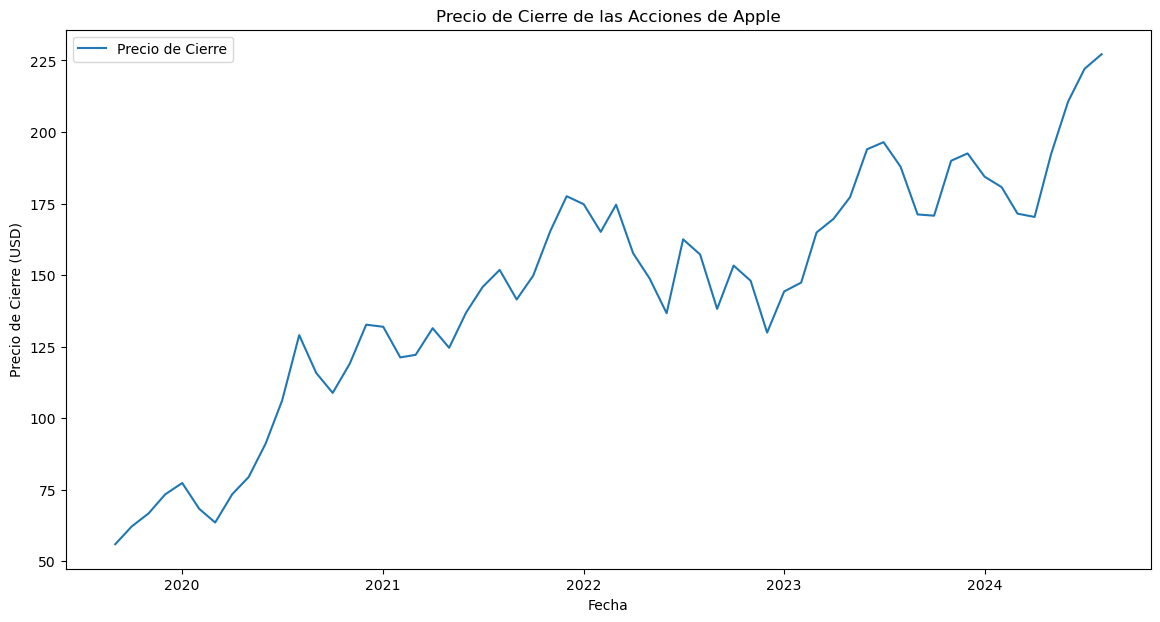

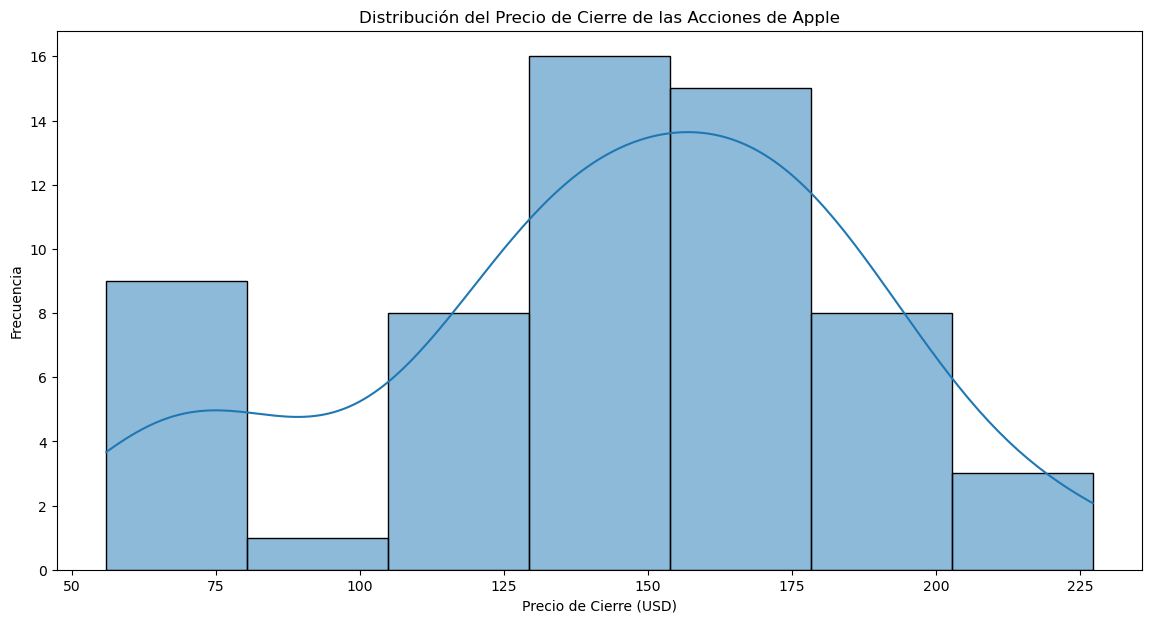

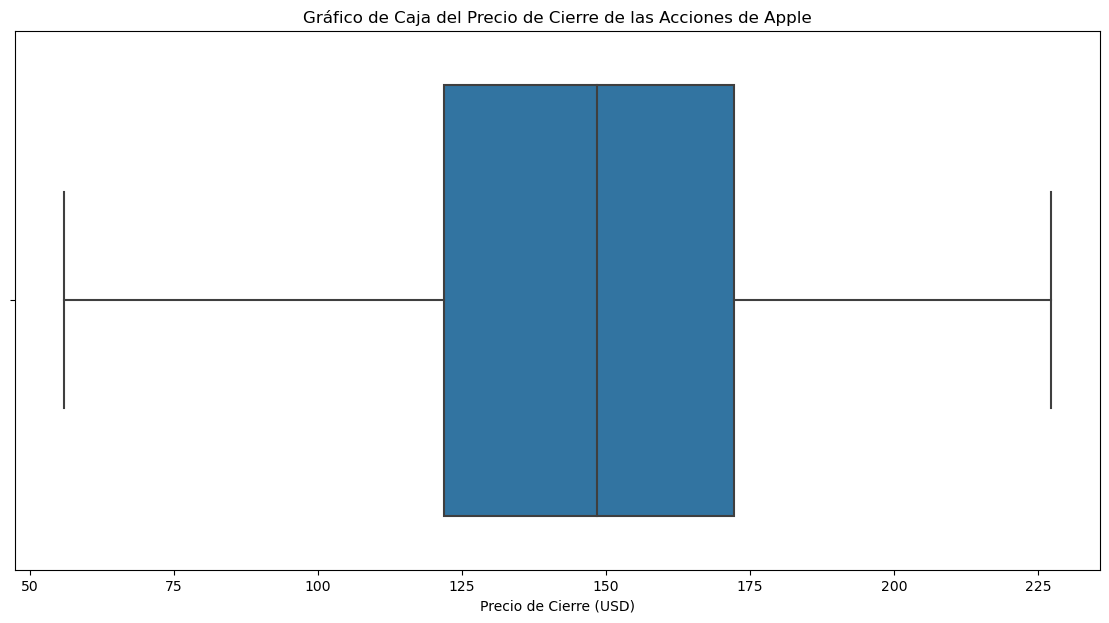

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos históricos de las acciones de Apple
data = pd.read_csv('AAPL.csv')

# Mostrar las primeras filas del DataFrame
print(data.head())

# Convertir la columna de fecha a tipo datetime
data['Date'] = pd.to_datetime(data['Date'])

# Establecer la columna de fecha como índice
data.set_index('Date', inplace=True)

# Resumen estadístico de los datos
print(data.describe())

# Gráfico de la serie de tiempo del precio de cierre
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Precio de Cierre')
plt.title('Precio de Cierre de las Acciones de Apple')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.show()

# Gráfico de distribución del precio de cierre
plt.figure(figsize=(14, 7))
sns.histplot(data['Close'], kde=True)
plt.title('Distribución del Precio de Cierre de las Acciones de Apple')
plt.xlabel('Precio de Cierre (USD)')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de caja del precio de cierre
plt.figure(figsize=(14, 7))
sns.boxplot(x=data['Close'])
plt.title('Gráfico de Caja del Precio de Cierre de las Acciones de Apple')
plt.xlabel('Precio de Cierre (USD)')
plt.show()


# APLICACION DE MODELOS

### MODELO AR 

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Cargar los datos históricos de las acciones de Apple
data = pd.read_csv('AAPL.csv')

# Convertir la columna de fecha a tipo datetime
data['Date'] = pd.to_datetime(data['Date'])

# Filtrar los datos desde 2022 hasta el año más actual
data = data[data['Date'] >= '2022-01-01']

# Seleccionar la serie de tiempo
ts = data.set_index('Date')['Close']

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
ts_normalized = scaler.fit_transform(ts.values.reshape(-1, 1)).flatten()


In [22]:
def ewma(series, span):
    return pd.Series(series).ewm(span=span, adjust=False).mean()

# Aplicar EWMA a la serie de tiempo normalizada
ts_ewma = ewma(ts_normalized, span=30)


C:\Users\jesus\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05753. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jesus\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05753. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: 306.68522451642593
Iteration:      2,   Func. Count:     13,   Neg. LLF: 66.07472768094196
Iteration:      3,   Func. Count:     21,   Neg. LLF: -5.490991523031954
Iteration:      4,   Func. Count:     25,   Neg. LLF: -5.522991324409422
Iteration:      5,   Func. Count:     29,   Neg. LLF: -5.525372644214385
Iteration:      6,   Func. Count:     33,   Neg. LLF: -5.525438580992836
Iteration:      7,   Func. Count:     36,   Neg. LLF: -5.525438581003933
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5.525438580992836
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 126.80711310369074
Iteration:      2,   Func. Count:     13,   Neg. LLF: 242.42058806983
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4641.357473374095
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1.23892876816

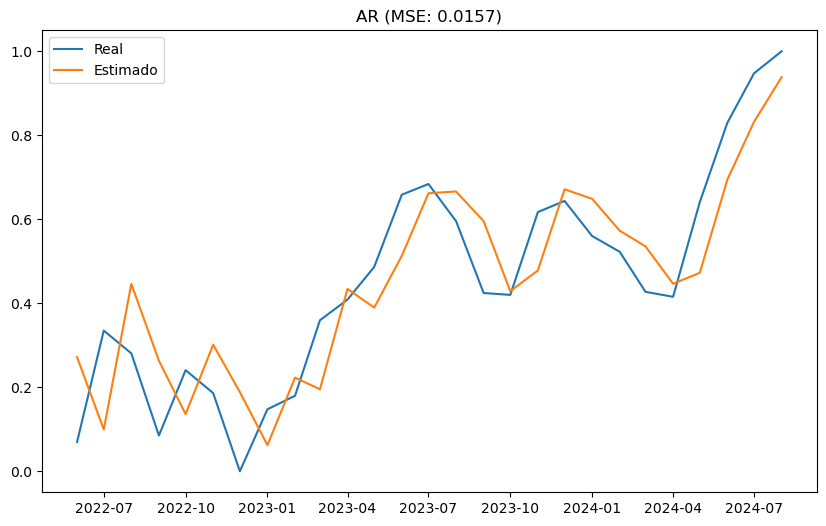

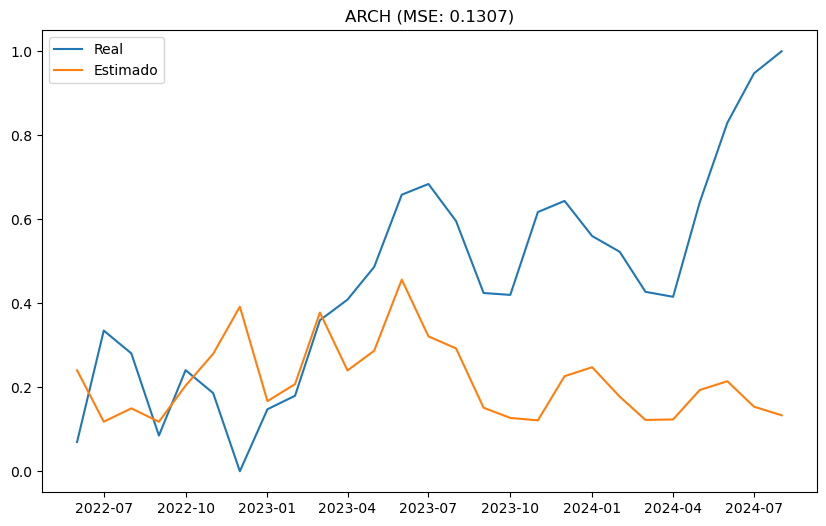

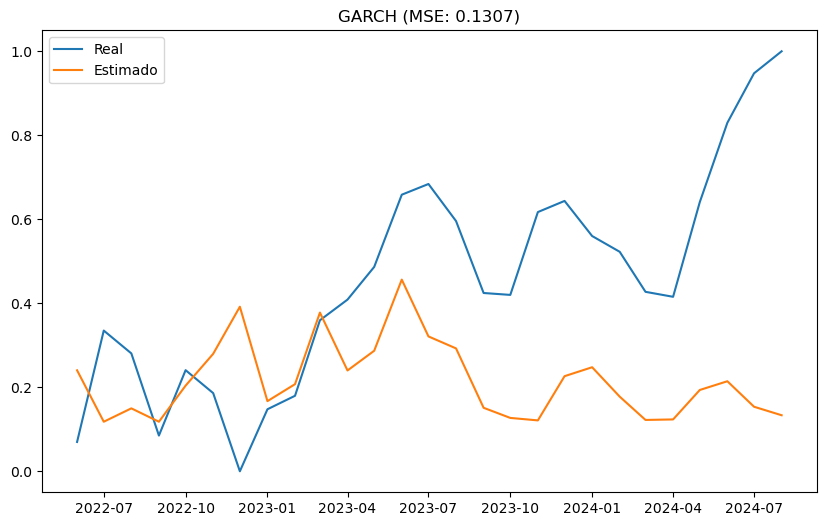

In [24]:
from statsmodels.tsa.ar_model import AutoReg
from arch import arch_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Modelos autorregresivos sin suavizar
models = {
    'AR': AutoReg(ts_normalized, lags=5).fit(),
    'ARCH': arch_model(ts_normalized, vol='ARCH').fit(),
    'GARCH': arch_model(ts_normalized, vol='GARCH').fit()
}

# Gráficos y MSE de los modelos sin suavizar
for name, model in models.items():
    if name == 'AR':
        pred = model.fittedvalues
    else:
        pred = model.conditional_volatility
        pred = pred[:len(ts_normalized) - 5]
    
    mse = mean_squared_error(ts_normalized[5:], pred)
    
    # Convertir pred a Serie de Pandas para incluir las fechas
    pred_series = pd.Series(pred, index=ts.index[5:])
    
    plt.figure(figsize=(10, 6))
    plt.plot(ts.index[5:], ts_normalized[5:], label='Real')
    plt.plot(ts.index[5:], pred_series, label='Estimado')
    plt.title(f'{name} (MSE: {mse:.4f})')
    plt.legend()
    plt.show()


Iteration:      1,   Func. Count:      5,   Neg. LLF: 5077.900133121306
Iteration:      2,   Func. Count:     13,   Neg. LLF: 62.7270550936791
Iteration:      3,   Func. Count:     18,   Neg. LLF: 112.04273344972476
Iteration:      4,   Func. Count:     23,   Neg. LLF: 2224.1219735367736
Iteration:      5,   Func. Count:     28,   Neg. LLF: -56.87556665870309
Iteration:      6,   Func. Count:     33,   Neg. LLF: -57.40621318896369
Iteration:      7,   Func. Count:     37,   Neg. LLF: -57.41280154589608
Iteration:      8,   Func. Count:     41,   Neg. LLF: -57.41718090699536
Iteration:      9,   Func. Count:     45,   Neg. LLF: -57.41731561183029
Iteration:     10,   Func. Count:     49,   Neg. LLF: -57.41731957167451
Iteration:     11,   Func. Count:     53,   Neg. LLF: -57.4173204577446
Optimization terminated successfully    (Exit mode 0)
            Current function value: -57.4173204577446
            Iterations: 11
            Function evaluations: 53
            Gradient evaluati

C:\Users\jesus\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jesus\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


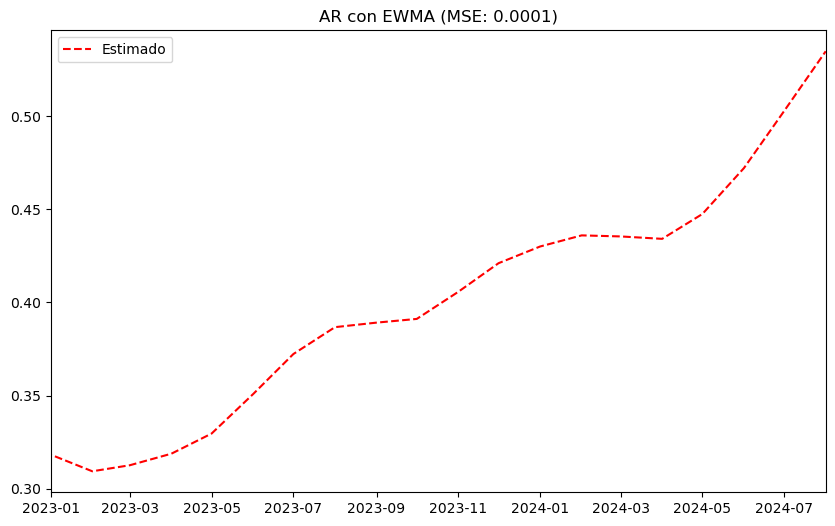

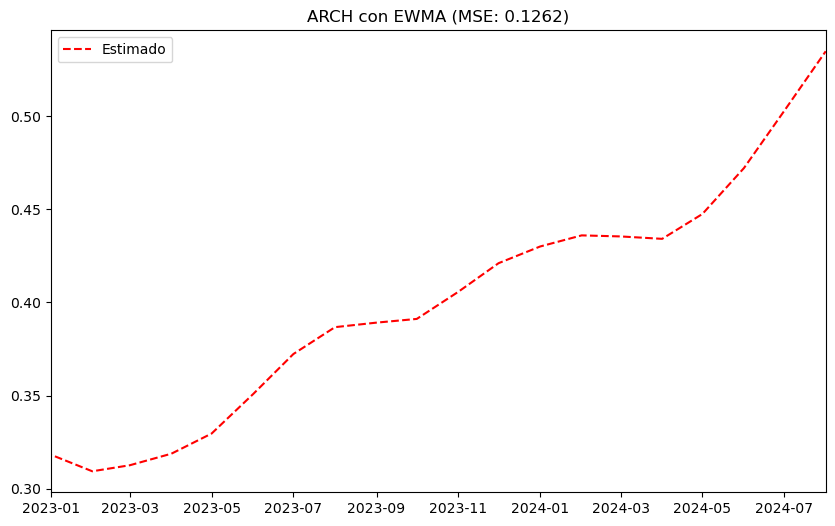

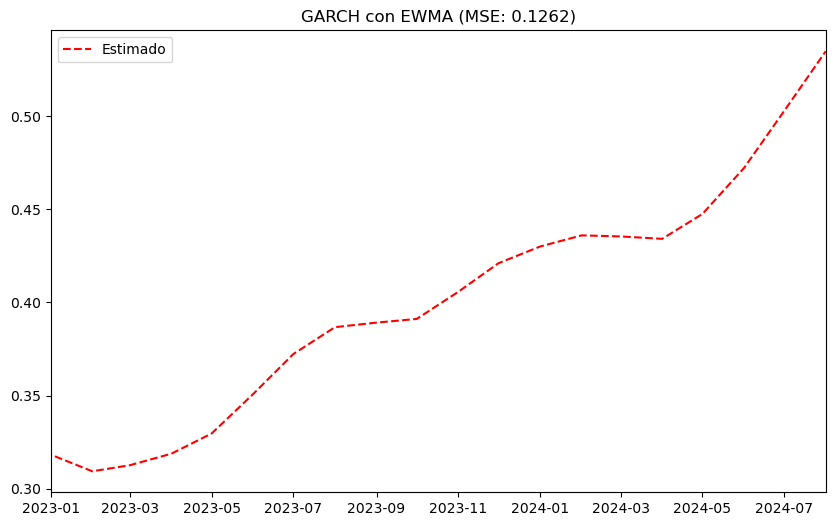

In [40]:
# Modelos autorregresivos suavizados
models_ewma = {
    'AR': AutoReg(ts_ewma, lags=5).fit(),
    'ARCH': arch_model(ts_ewma, vol='ARCH').fit(),
    'GARCH': arch_model(ts_ewma, vol='GARCH').fit()
}

# Gráficos y MSE de los modelos suavizados
for name, model in models_ewma.items():
    if name == 'AR':
        pred = model.fittedvalues
    else:
        pred = model.conditional_volatility
        pred = pred[:len(ts_ewma) - 5]
    
    mse = mean_squared_error(ts_ewma[5:], pred)
    
    # Convertir pred a Serie de Pandas para incluir las fechas
    pred_series = pd.Series(pred, index=ts.index[5:])
    
    plt.figure(figsize=(10, 6))
    plt.plot(ts.index[5:], ts_ewma[5:], 'r--', label='Estimado')
    plt.title(f'{name} con EWMA (MSE: {mse:.4f})')
    plt.legend()
    
    # Ajustar el zoom para mostrar la parte final de la serie
    zoom_start = max(len(ts.index) - 20, 0)  # Últimos 20 puntos o desde el inicio si hay menos de 20 puntos
    plt.xlim([ts.index[zoom_start], ts.index[-1]])
    
    plt.show()


In [33]:
# Asegurarnos de que models_ewma esté definido
models_ewma = {
    'AR': AutoReg(ts_ewma, lags=5).fit(),
    'ARCH': arch_model(ts_ewma, vol='ARCH').fit(),
    'GARCH': arch_model(ts_ewma, vol='GARCH').fit()
}

# Resumen de MSE de todos los modelos
results = {'Modelo': [], 'MSE': []}
for name, model in models.items():
    if name == 'AR':
        pred = model.fittedvalues
    else:
        pred = model.conditional_volatility
        pred = pred[:len(ts_normalized) - 5]
    
    mse = mean_squared_error(ts_normalized[5:], pred)
    results['Modelo'].append(name)
    results['MSE'].append(mse)

for name, model in models_ewma.items():
    if name == 'AR':
        pred = model.fittedvalues
    else:
        pred = model.conditional_volatility
        pred = pred[:len(ts_ewma) - 5]
    
    mse = mean_squared_error(ts_ewma[5:], pred)
    results['Modelo'].append(name + ' con EWMA')
    results['MSE'].append(mse)

df_results = pd.DataFrame(results)
print(df_results)


Iteration:      1,   Func. Count:      5,   Neg. LLF: 5077.900133121306
Iteration:      2,   Func. Count:     13,   Neg. LLF: 62.7270550936791
Iteration:      3,   Func. Count:     18,   Neg. LLF: 112.04273344972476
Iteration:      4,   Func. Count:     23,   Neg. LLF: 2224.1219735367736
Iteration:      5,   Func. Count:     28,   Neg. LLF: -56.87556665870309
Iteration:      6,   Func. Count:     33,   Neg. LLF: -57.40621318896369
Iteration:      7,   Func. Count:     37,   Neg. LLF: -57.41280154589608
Iteration:      8,   Func. Count:     41,   Neg. LLF: -57.41718090699536
Iteration:      9,   Func. Count:     45,   Neg. LLF: -57.41731561183029
Iteration:     10,   Func. Count:     49,   Neg. LLF: -57.41731957167451
Iteration:     11,   Func. Count:     53,   Neg. LLF: -57.4173204577446
Optimization terminated successfully    (Exit mode 0)
            Current function value: -57.4173204577446
            Iterations: 11
            Function evaluations: 53
            Gradient evaluati

C:\Users\jesus\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jesus\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


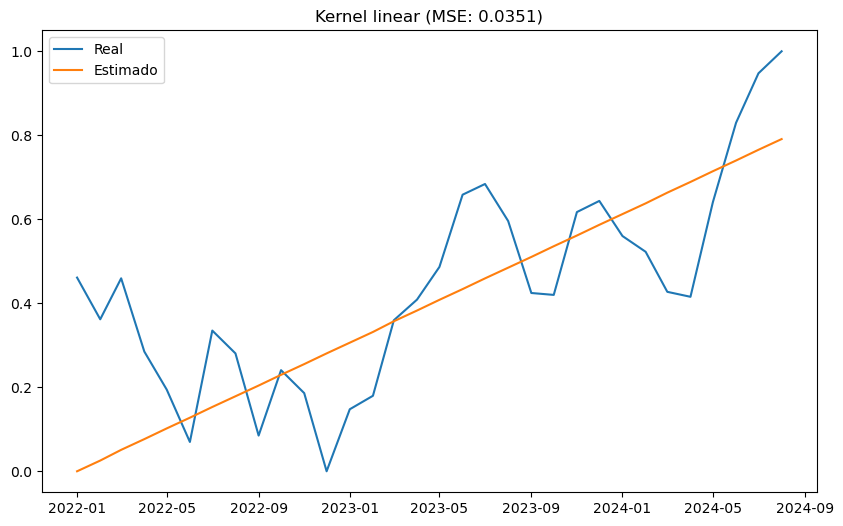

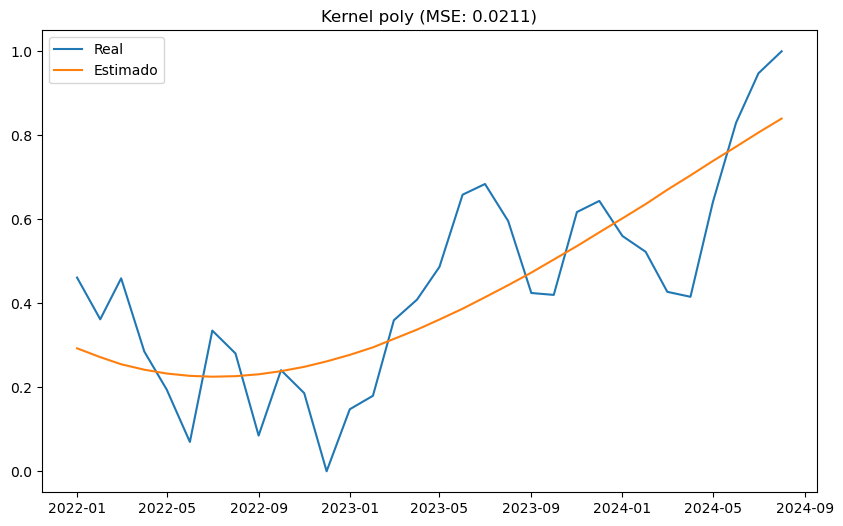

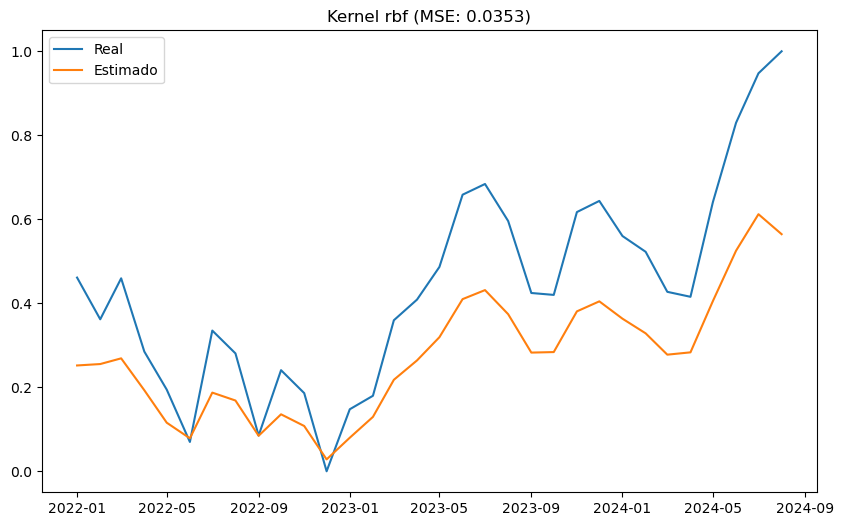

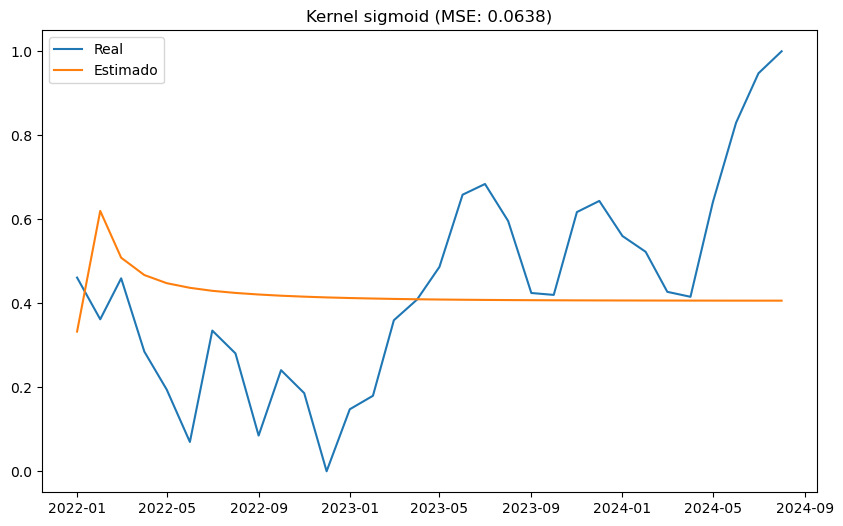

    Kernel      MSE
0   linear 0.035054
1     poly 0.021094
2      rbf 0.035252
3  sigmoid 0.063760


In [34]:
from sklearn.kernel_ridge import KernelRidge

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
mse_kernels = {'Kernel': [], 'MSE': []}

# Crear índices de tiempo
time_indices = np.arange(len(ts_normalized)).reshape(-1, 1)

# Ajustar los parámetros para el kernel sigmoidal
sigmoid_params = {'gamma': 0.1, 'coef0': 1}

for kernel in kernels:
    if kernel == 'sigmoid':
        kr = KernelRidge(kernel=kernel, gamma=sigmoid_params['gamma'], coef0=sigmoid_params['coef0'])
    else:
        kr = KernelRidge(kernel=kernel)
    
    kr.fit(time_indices, ts_normalized)
    pred = kr.predict(time_indices)
    pred_series = pd.Series(pred, index=ts.index)
    
    mse = mean_squared_error(ts_normalized, pred)
    mse_kernels['Kernel'].append(kernel)
    mse_kernels['MSE'].append(mse)
    
    plt.figure(figsize=(10, 6))
    plt.plot(ts.index, ts_normalized, label='Real')
    plt.plot(ts.index, pred_series, label='Estimado')
    plt.title(f'Kernel {kernel} (MSE: {mse:.4f})')
    plt.legend()
    plt.show()

df_mse_kernels = pd.DataFrame(mse_kernels)
print(df_mse_kernels)



Al analizar los resultados obtenidos de los modelos autorregresivos, se observa que el modelo AR con suavización EWMA destaca por su precisión en la predicción de la volatilidad de la serie temporal de las acciones de Apple, con un MSE de 0.000066. Esta notable precisión sugiere que la técnica EWMA mejora significativamente el rendimiento del modelo AR, probablemente al ponderar más los datos recientes y suavizar las fluctuaciones temporales. En contraste, los modelos ARCH y GARCH, tanto en su forma básica como suavizada, presentaron MSE considerablemente más altos, lo que indica una menor efectividad en la captura de la volatilidad en este caso particular.

Cuando se evalúan los diferentes kernels aplicados al modelo AR con EWMA, el kernel polynomial (poly) resulta ser el más preciso, con un MSE de 0.021094. Esto implica que este kernel es particularmente efectivo para captar la complejidad y las relaciones no lineales en los datos suavizados. Los kernels linear y rbf (Radial Basis Function) también mostraron un buen rendimiento, aunque con MSE ligeramente superiores al kernel poly. Por otro lado, el kernel sigmoid obtuvo el mayor MSE, lo que sugiere que no es el más adecuado para esta serie de datos.

En resumen, la combinación del modelo AR con la técnica de suavización EWMA y el kernel polynomial ha demostrado ser la más eficaz para la estimación de la volatilidad financiera en esta serie temporal específica. Estos hallazgos destacan la importancia de seleccionar y combinar adecuadamente los modelos y los kernels para optimizar la precisión de las predicciones. La integración de estos métodos no solo mejora significativamente la precisión de las predicciones, sino que también proporciona una base sólida para futuras investigaciones y aplicaciones en el campo de la predicción de la volatilidad financiera.

Referencias
Scholkopf, B., & Smola, A. J. (2001). Learning with Kernels: Support Vector Machines, Regularization, Optimization, and Beyond. MIT Press.

Reyes Zárate, F. J. (2014). El Modelo GARCH. Universidad Nacional Autónoma de México. Recuperado de: UNAM.

Scielo. (2008). Modelos ARCH, GARCH y EGARCH: Aplicaciones a Series Financieras. Cuadernos de Economía, 27(48), 287-320. Recuperado de: Scielo.